In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.backends import cudnn

from copy import deepcopy
import numpy as np

import sys
sys.path.append('../data/cifar100/')  
from cifar100_loader import CIFAR100DataLoader
from models.model import LeNet5 #import the model
from utils.utils import evaluate

# Constants

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Check whether a GPU is available and if so, use it
print(DEVICE)
#Momentum and batch size have not been tuned
BATCH_SIZE = 64    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
LOG_FREQUENCY = 10

cuda


# Data loading

In [3]:
#10% of the dataset kept for validation
data_loader = CIFAR100DataLoader(batch_size=BATCH_SIZE, validation_split=0.1, download=True, num_workers=4, pin_memory=True)
trainloader, validloader, testloader = data_loader.train_loader, data_loader.val_loader, data_loader.test_loader
#The previous function has been verified to ensure that the distribution among classes
#is preserved in the training and validation sets

100.0%


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Prepare training

In [4]:
#Modified version of LeNet5 to work with CIFAR100, paper cited in model.py
model = LeNet5().to(DEVICE) # Create the model
# Define loss function -> log_softmax used by the model, NLL is required
criterion = nn.NLLLoss()

# Schedulers
List of schedulers to be experimented 

In [5]:
def get_scheduler_factory(num_epochs):
    """
    Return a set of predefined learning rate scheduler factories with reasonable parameters.

    Args:
        num_epochs (int): Total number of epochs.

    Returns:
        list: List of tuples with scheduler names and factory functions.
    """
    schedulers = [
        # StepLR
        ("StepLR (step_size=num_epochs//3, gamma=0.1)",
         lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs // 3, gamma=0.1)),

        # CosineAnnealingLR
        ("CosineAnnealingLR (T_max=num_epochs//3, eta_min=1e-4)",
         lambda optimizer: torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs // 3, eta_min=1e-4)),

        # ExponentialLR
        ("ExponentialLR (gamma=0.9)",
         lambda optimizer: torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)),
    ]
    return schedulers


# Training loop

In [6]:
def train(num_epochs, scheduler,optimizer):
    val_accuracies = []
    val_losses = []
    train_accuracies = []
    train_losses = []
    cudnn.benchmark  # Calling this optimizes runtime

    best_val_acc = 0.0  
    best_model_state = None  # The model with the best accuracy

    # Training loop
    for epoch in range(num_epochs): 
        epoch_train_loss = 0.0 
        correct = 0  # Number of correct predictions
        total = 0  # Total number of examples
        for data, targets in trainloader:
            data = data.to(DEVICE)        # Move the data to the GPU
            targets = targets.to(DEVICE)  # Move the targets to the GPU
            model.train()                # Set Network to train mode
            optimizer.zero_grad()         # Zero the gradients
            outputs = model(data)         # Pass data through the model
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()               # Backpropagation
            optimizer.step()              # Update model parameters
            # Accumulate training loss
            epoch_train_loss += loss.item() * data.size(0)  # Multiply by batch dimension
            # Compute accuracy
            _, predicted = outputs.max(1)  # Predictions
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

        # Compute the average training loss and accuracy
        train_loss = epoch_train_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        # Evaluate on the validation set, done every epoch
        val_acc, val_loss = evaluate(model, validloader)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        # Update the best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())  # Save the current model state
            #print(f"New best model found with accuracy: {val_acc*100:.2f}%")
        # Evaluate on the training set
        if(epoch%LOG_FREQUENCY==0):
            print(f"--> best validation accuracy: {best_val_acc:.2f} epoch: {epoch+1}")
            print(f"--> validation loss: {val_loss:.4f}-- training loss: {train_loss:.4f}")
        # Step the scheduler
        scheduler.step()
        #print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Alla fine del training, ritorna il miglior modello
    model.load_state_dict(best_model_state)
    return train_accuracies, train_losses, val_accuracies, val_losses, model


# Test

In [7]:
def test(model, testloader):
    """
    Test the model on the test set.
    """
    accuracy, loss = evaluate(model, testloader)
    return accuracy, loss

# Hyperparameters tuning

In [8]:
# Generate 3 values for the learning rate (lr) between 1e-3 and 1e-1 in log-uniform
learning_rates = np.logspace(-3, -1, num=3)

# Generate 4 values for the weight decay (lr) between 1e-4 and 1e-1 in log-uniform
weight_decays = np.logspace(-4, -1, num=4)

print("Learning Rate Values (log-uniform):", learning_rates)
print("Weight Decay Values (log-uniform):", weight_decays)

Learning Rate Values (log-uniform): [0.001 0.01  0.1  ]
Weight Decay Values (log-uniform): [0.0001 0.001  0.01   0.1   ]


In [9]:
num_epochs = 20  # low value for parameter tuning

scheduler_factories = get_scheduler_factory(num_epochs)
results = []
best_validation_accuracy_overall = 0.0
best_setting = None
print('Starting the parameter tuning loop...')
for lr in learning_rates:
    for wd in weight_decays:
        for scheduler_name, scheduler_factory in scheduler_factories:
            # Reset the model
            model = LeNet5().to(DEVICE)
            # Create the optimizer
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
            # Create the scheduler
            scheduler = scheduler_factory(optimizer)
            # Ezecute training
            train_accuracies, train_losses, val_accuracies, val_losses, model = train(num_epochs, scheduler,optimizer)
            # Print the best validation accuracy
            best_val_accuracy = max(val_accuracies)
            if best_val_accuracy > best_validation_accuracy_overall:
                best_validation_accuracy_overall = best_val_accuracy
                best_setting = (lr, wd, scheduler_name)
            print(f'Learning Rate: {lr}, Weight Decay: {wd}, Scheduler: {scheduler_name}, Best Validation Accuracy: {best_val_accuracy*100:.2f}%')

            results.append({
                'learning_rate': lr,
                'weight_decay': wd,
                'scheduler_name': scheduler_name,
                'train_accuracies': train_accuracies,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'val_losses': val_losses,
            })
print("Finished training loop.")
print(f'Best validation accuracy overall: {best_validation_accuracy_overall*100:.2f}%')
print(f'Best setting: {best_setting}')

Starting the parameter tuning loop...
--> best validation accuracy: 0.02
--> validation loss: 4.5638
--> training loss: 4.5945
--> best validation accuracy: 0.18
--> validation loss: 3.4117
--> training loss: 3.4446
Learning Rate: 0.001, Weight Decay: 0.0001, Scheduler: StepLR (step_size=num_epochs//3, gamma=0.1), Best Validation Accuracy: 18.92%
--> best validation accuracy: 0.02
--> validation loss: 4.5879
--> training loss: 4.6011
--> best validation accuracy: 0.16
--> validation loss: 3.6044
--> training loss: 3.7032
Learning Rate: 0.001, Weight Decay: 0.0001, Scheduler: CosineAnnealingLR (T_max=num_epochs//3, eta_min=1e-4), Best Validation Accuracy: 24.56%
--> best validation accuracy: 0.03
--> validation loss: 4.5334
--> training loss: 4.5877
--> best validation accuracy: 0.19
--> validation loss: 3.3946
--> training loss: 3.4490
Learning Rate: 0.001, Weight Decay: 0.0001, Scheduler: ExponentialLR (gamma=0.9), Best Validation Accuracy: 22.74%
--> best validation accuracy: 0.03
--

# Plotting and saving results

In [10]:
import matplotlib.pyplot as plt
import os
import re  # Imported module for regular expressions

def plot_results(results, save_dir='./plots_centralized'):
    """
    Save plots comparing training accuracy and validation accuracy per epoch for each combination of hyperparameters.

    Args:
        results (list): List of dictionaries, where each dictionary contains:
                        - 'learning_rate': Learning rate used.
                        - 'weight_decay': Weight decay used.
                        - 'scheduler_name': Name of the scheduler.
                        - 'train_accuracies': List of training accuracies.
                        - 'val_accuracies': List of validation accuracies.
        save_dir (str): Directory where the plots will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)

    for res in results:
        # Extract hyperparameter values
        lr = res['learning_rate']
        wd = res['weight_decay']
        scheduler_name = res['scheduler_name']

        # Clean up the scheduler name for filename compatibility
        clean_scheduler_name = re.sub(r"[^a-zA-Z0-9]", "_", scheduler_name)  # Sostituisce i caratteri non alfanumerici con '_'

        # Generate a unique filename prefix for each configuration
        file_prefix = f"LR_{lr}_WD_{wd}_Scheduler_{clean_scheduler_name}"

        # Plot training and validation accuracy per epoch
        plt.figure(figsize=(12, 6))
        plt.plot(res['train_accuracies'], label='Training Accuracy')
        plt.plot(res['val_accuracies'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Training vs Validation Accuracy (LR={lr}, WD={wd}, Scheduler={scheduler_name})")
        plt.legend()
        accuracy_plot_path = os.path.join(save_dir, f"{file_prefix}_training_vs_validation_accuracy.png")
        plt.savefig(accuracy_plot_path)
        plt.close()

    print(f"Plots saved to directory: {save_dir}")

#Plot only the best result 
filtered_results = [res for res in results if res['learning_rate'] == 0.01 and res['weight_decay'] == 0.0001 and res['scheduler_name']=="CosineAnnealingLR (T_max=num_epochs//3, eta_min=1e-4)"]
plot_results(filtered_results)

Plots saved to directory: ./plots_centralized


# Plot the loss for the results with the learning rate = 0.01 and weight_decay = 0.0001

[{'learning_rate': 0.01, 'weight_decay': 0.0001, 'scheduler_name': 'StepLR (step_size=num_epochs//3, gamma=0.1)', 'train_accuracies': [0.06542222222222223, 0.14657777777777778, 0.2049111111111111, 0.2521111111111111, 0.2876444444444444, 0.3120888888888889, 0.3896, 0.4099555555555556, 0.41644444444444445, 0.4292888888888889, 0.4325555555555556, 0.44044444444444447, 0.45166666666666666, 0.45713333333333334, 0.4575111111111111, 0.45668888888888887, 0.4585111111111111, 0.4580222222222222, 0.45755555555555555, 0.45986666666666665], 'train_losses': [4.145863355721367, 3.5933727416144476, 3.2530655670166015, 3.005087770419651, 2.832871858215332, 2.698334000693427, 2.3315560606214736, 2.2496879278818764, 2.204069110467699, 2.169746749030219, 2.1334504072825116, 2.111355479219225, 2.053260225423177, 2.041192229800754, 2.0308174122916327, 2.0266431432300145, 2.026934356096056, 2.0226869987911646, 2.0240914125654434, 2.0138023563808867], 'val_accuracies': [0.115, 0.1902, 0.2254, 0.2776, 0.2982, 0

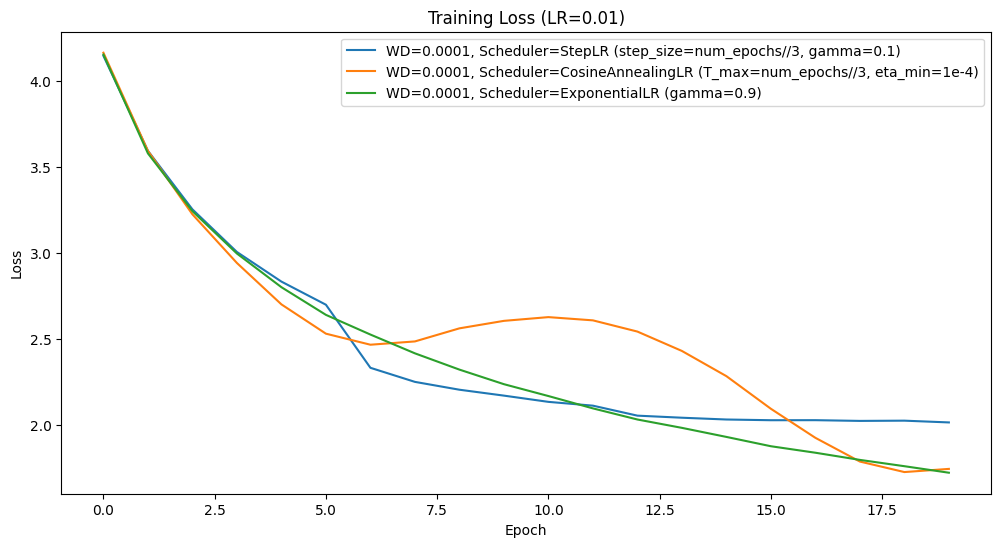

In [11]:
import copy
resLR = []
filtered_results = [res for res in results if res['learning_rate'] == 0.01 and res['weight_decay'] == 0.0001]

# Stampa dei risultati filtrati per verificare
print(filtered_results)

#plot only train losses
plt.figure(figsize=(12, 6))
for res in filtered_results:
    plt.plot(res['train_losses'], label=f"WD={res['weight_decay']}, Scheduler={res['scheduler_name']}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Training Loss (LR=0.01)")
plt.legend()
plt.show()


# Final model
Given the observations done in the sections before and analyzing all the plots, the following is the configuration that brought the best results. More details are reported in Report.md

In [12]:
NUM_EPOCHS = 200 
#Values found in the previous step that gave the best accuracy
LR = 0.01
WD =  0.0001

In [13]:
model = LeNet5().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WD)
scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS//3, eta_min=1e-4)

In [ ]:
train_accuracies, train_losses, val_accuracies, val_losses, model = train(NUM_EPOCHS, scheduler, optimizer)
test_accuracy, test_loss = test(model, testloader)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

--> best validation accuracy: 0.11
--> validation loss: 3.7737
--> training loss: 4.1419
--> best validation accuracy: 0.40
--> validation loss: 2.3610
--> training loss: 2.3025
--> best validation accuracy: 0.45
--> validation loss: 2.1902
--> training loss: 1.8648
--> best validation accuracy: 0.47
--> validation loss: 2.1773
--> training loss: 1.5296
--> best validation accuracy: 0.49
--> validation loss: 2.1777
--> training loss: 1.2169
--> best validation accuracy: 0.51
--> validation loss: 2.2130
--> training loss: 0.9371
--> best validation accuracy: 0.51
--> validation loss: 2.2791
--> training loss: 0.7911
--> best validation accuracy: 0.51
--> validation loss: 2.3104
--> training loss: 0.7550
--> best validation accuracy: 0.51
--> validation loss: 2.3519
--> training loss: 0.8172
--> best validation accuracy: 0.51
--> validation loss: 2.4010
--> training loss: 0.9829
--> best validation accuracy: 0.51
--> validation loss: 2.4167
--> training loss: 1.2249
--> best validation a

# Storing results

In [60]:
import pickle

def save_results(train_accuracies, train_losses, val_accuracies, val_losses, model, results_dir="centralized_results/"):
    """
    Save the results and the model in a pickle file.
    
    Args:
        train_accuracies (list): List of training accuracies per epoch.
        train_losses (list): List of training losses per epoch.
        val_accuracies (list): List of validation accuracies per epoch.
        val_losses (list): List of validation losses per epoch.
        model (torch.nn.Module): Training model.
        results_dir (str): Directory where the results will be saved.
    """
    # Assicura che la directory esista
    os.makedirs(results_dir, exist_ok=True)
    
    # Percorso del file
    results_file = os.path.join(results_dir, "centralized_cosine_200epochs.pkl")
    
    # Salva i risultati e il modello
    with open(results_file, "wb") as f:
        pickle.dump({
            "train_accuracies": train_accuracies,
            "train_losses": train_losses,
            "val_accuracies": val_accuracies,
            "val_losses": val_losses,
            "model": model.state_dict()  # Save the state of the model 
        }, f)
    print(f"Results and model saved in {results_file}")


def plot_results(train_accuracies, train_losses, val_accuracies, val_losses, plots_dir="plots_centralized/"):
    """
    Generate and save plots comparing training accuracy and validation accuracy per epoch.
    
    Args:
        train_accuracies (list): list of training accuracies per epoch.
        train_losses (list): list of training losses per epoch.
        val_accuracies (list): List of validation accuracies per epoch.
        val_losses (list): List of validation losses per epoch.
        plots_dir (str): Directory where the plots will be saved.
    """
    # Assicura che la directory esista
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot train_accuracies vs val_accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Train vs Validation Accuracy", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    accuracy_plot_path = os.path.join(plots_dir, "final_validation_centralized_cosine_200epochs.png")
    plt.savefig(accuracy_plot_path, format="png", dpi=300)
    plt.close()
    print(f"Train vs Validation Accuracy plot saved in {accuracy_plot_path}")
    
    # Plot train_losses vs val_losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Train vs Validation Loss", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    loss_plot_path = os.path.join(plots_dir, "final_loss_centralized_cosine_200epochs.png")
    plt.savefig(loss_plot_path, format="png", dpi=300)
    plt.close()
    print(f"Train vs Validation Loss plot saved in {loss_plot_path}")

# Save results in order to avoid retraining
save_results(train_accuracies, train_losses, val_accuracies, val_losses, model)

# Generate and save plots for the final results
plot_results(train_accuracies, train_losses, val_accuracies, val_losses)


Results and model saved in centralized_results/centralized_cosine_350epochs.pkl
Train vs Validation Accuracy plot saved in plots_centralized/final_validation_centralized_cosine_350epochs.png
Train vs Validation Loss plot saved in plots_centralized/final_loss_centralized_cosine_350epochs.png
